Recommendation Systems using TensorFlow
Builds a recommendation engine using Movie Lens data
We use the 1M data set for building our recommendation engine. The 1M data contain 1,000,209 anonymous ratings

Ratings for approximately 3,900 movies
Ratings provided by 6,040 MovieLens users who joined MovieLens in 2000

inspired by https://www.youtube.com/watch?v=TNiWwaMGYzo and https://github.com/karthikmswamy/RecSys/blob/master/Train_RecSys.ipynb

https://github.com/songgc/TF-recomm


Wiki: https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)
Matrix factorization is a class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.[1] This family of methods became widely known during the Netflix prize challenge due to its effectiveness as reported by Simon Funk in his 2006 blog post,[2] where he shared his findings with the research community.
The original algorithm proposed by Simon Funk in his blog post [2] factorized the user-item rating matrix as the product of two lower dimensional matrices, the first one has a row for each user, while the second has a column for each item. The row or column associated to a specific user or item is referred to as latent factors.[3] Note that, despite its name, in FunkSVD no singular value decomposition is applied.

In [62]:
from IPython.display import Image, display

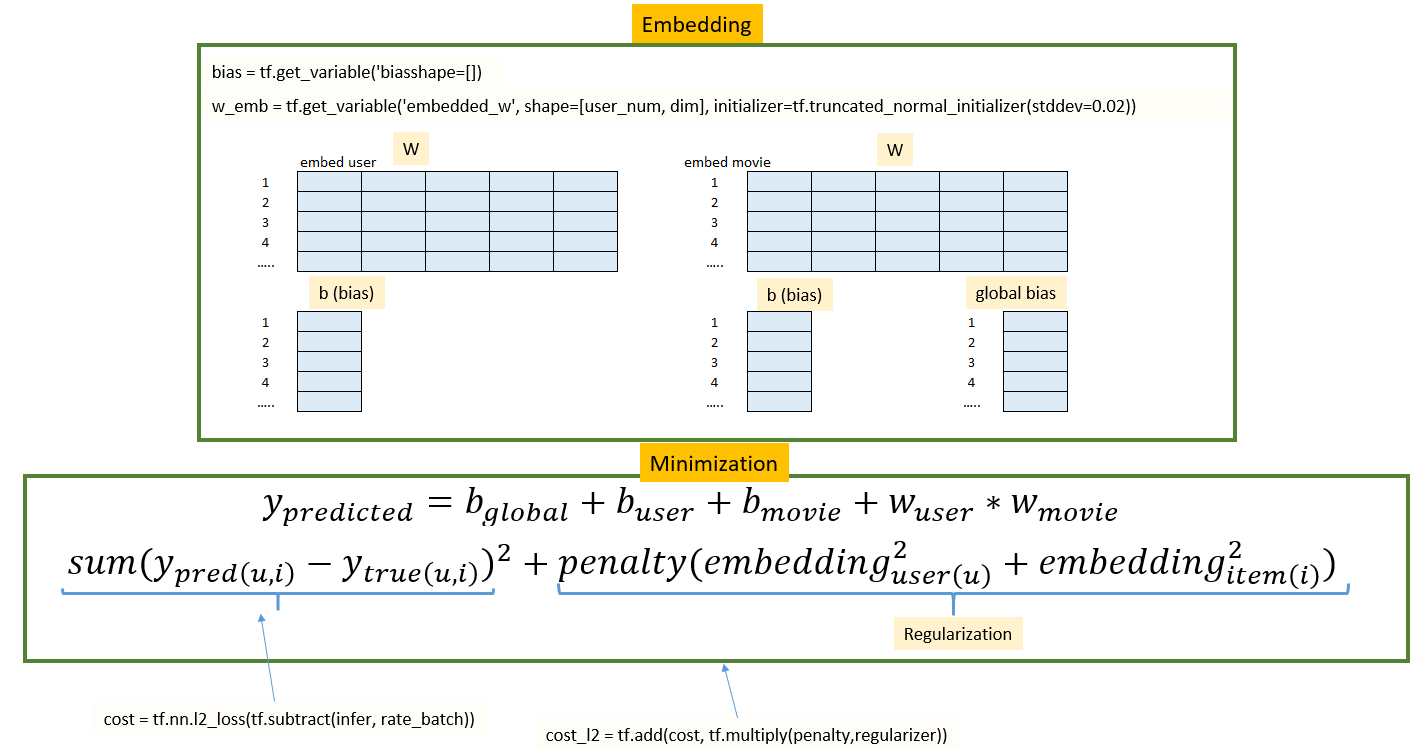

In [66]:
display(Image(filename='fig_1.PNG', embed=True, width=1000))

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import deque

C:\Users\gj310e\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [3]:
columns = ['UserIDs','MovieIDs','Ratings','Timestamp']
data = pd.read_csv('ml-1m\\ratings.dat', sep='::', names=columns)

C:\Users\gj310e\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
data.head()

,UserIDs,MovieIDs,Ratings,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# labels
print(set(data['Ratings']))

{1, 2, 3, 4, 5}


In [6]:
# create test ans train set
rows = len(data)
data = data.iloc[np.random.permutation(rows)].reset_index(drop=True)
split_index = int(rows*0.9)
data_train = data[:split_index]
data_test = data[split_index:]

In [7]:
def clip(x):
    return np.clip(x, 1.0, 5.0)

The objective is predicted by formula:

y_pred[u, i] = global__bias + bias_user[u] + bias_item_[i] + <embedding_user[u], embedding_item[i]>

Minimize by:

sum_{u, i} |y_pred[u, i] - y_true[u, i]|^2 + lambda(embedding_user[u]|^2 + embedding_item[i]^2)

In [8]:
# create a model for 
def model(user_batch, movie_batch, user_num, movie_num, dim=5):
    bias_global = tf.get_variable('bias_global', shape=[])
    w_bias_movie = tf.get_variable('embeddings_bias_movie', shape=[movie_num])
    w_bias_user = tf.get_variable('embeddings_bias_user',shape=[user_num])
    
    bias_user = tf.nn.embedding_lookup(w_bias_user, user_batch, name='bias_user_values')
    bias_movie = tf.nn.embedding_lookup(w_bias_movie, movie_batch, name='bias_movie_values')
    
    w_emb_user = tf.get_variable('embedded_w_user', shape=[user_num, dim],
                            initializer=tf.truncated_normal_initializer(stddev=0.02))
    w_emb_movie = tf.get_variable('embedded_w_movie', shape=[movie_num, dim],
                             initializer=tf.truncated_normal_initializer(stddev=0.02))
    embed_user = tf.nn.embedding_lookup(w_emb_user, user_batch, name='w_user_val')
    embed_movie = tf.nn.embedding_lookup(w_emb_movie, movie_batch, name='w_movie_val')
    # tf.multiply(X, Y) does element-wise multiplication (not matrix)
    infer = tf.reduce_sum(tf.multiply(embed_user, embed_movie), 1) # avarege for columns, so num of rows will be same
    infer = tf.add(infer, bias_global)
    infer = tf.add(infer, bias_user)
    infer = tf.add(infer, bias_movie)
    # Computes half the L2 norm of a tensor without the sqrt
    regularizer = tf.add(tf.nn.l2_loss(embed_user), tf.nn.l2_loss(embed_movie))
    return infer, regularizer

In [9]:
def loss(infer, regularizer, rate_batch, learning_rate=0.1, reg=0.1):
    cost = tf.nn.l2_loss(tf.subtract(infer, rate_batch))
    penalty = tf.constant(reg, dtype=tf.float32, shape=[], name='l2')
    cost_l2 = tf.add(cost, tf.multiply(penalty,regularizer))
    train_op = tf.train.FtrlOptimizer(learning_rate).minimize(cost)
    return cost_l2, train_op

In [10]:
def get_batch(df, batch_size):
    n_batches = len(df)//batch_size
    df = df[:n_batches*batch_size]
    x = np.array(df.UserIDs) - 1    # -1 since Users are counted from 1, but embeddings is counted from 0(zero)
    y = np.array(df.MovieIDs) - 1   # same as above
    z = np.array(df.Ratings)
    
    for i in range(0, len(df), batch_size):
        yield x[i:i+batch_size], y[i:i+batch_size], z[i:i+batch_size]    

In [15]:
tf.reset_default_graph()

# create the graph object
graph = tf.Graph()

# list of constants and parameters
batch_size = 1000
movie_num = data.MovieIDs.max()
user_num = data.UserIDs.max()
n_epochs = 50

with graph.as_default():
    user_batch = tf.placeholder(tf.int32, shape=[None], name='user_batches')
    movie_batch = tf.placeholder(tf.int32, shape = [None], name='movie_batches')
    rate_batch = tf.placeholder(tf.float32, shape = [None], name='rate_batches')
    
    infer, regularizer = model(user_batch, movie_batch, user_num, movie_num, dim=5)
    cost_l2, train_op = loss(infer, regularizer, rate_batch, learning_rate=0.1, reg=0.1)
    saver = tf.train.Saver()

In [20]:
save_every_n = 500 # save every N iteration
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver = tf.train.Saver(max_to_keep = 100)
    counter = 0
    errors = deque(maxlen=batch_size)
    for e in range(n_epochs):
        for x, y, z in get_batch(data_train, batch_size):
            
            counter +=1
            start = time.time()
            feed = {user_batch:x, movie_batch:y, rate_batch:z}
            pred_batch, _ = sess.run([infer, train_op], feed_dict = feed)
            
            pred_batch = clip(pred_batch)
            errors.append(np.power(pred_batch - np.array(z), 2))
            if counter%500==0:
                end=time.time()
                print('epoch %d iteration %d  Train Error %f time %f secs'%(e,counter,np.mean(errors),end-start))
            # check the test set accuracy    
            if counter%1000==0:
                feed = {user_batch:(np.array(data_test.UserIDs)-1), 
                        movie_batch:(np.array(data_test.MovieIDs)-1), rate_batch:np.array(data_test.Ratings)}
                pred_batch = sess.run([infer], feed_dict = feed)
                pred_batch = clip(pred_batch)
                test_error = np.mean(np.power(pred_batch-np.array(data_test.Ratings),2))
                print('------ Test Error %f'%(test_error))
            if counter%save_every_n==0:
                saver.save(sess,"checkpoints/sentiment.ckpt")   
        # find final error
    feed = {user_batch:(np.array(data_test.UserIDs)-1), 
            movie_batch:(np.array(data_test.MovieIDs)-1), rate_batch:np.array(data_test.Ratings)}
    pred_batch = sess.run([infer], feed_dict = feed)
    pred_batch = clip(pred_batch)
    test_error = np.mean(np.power(pred_batch-np.array(data_test.Ratings),2))
    print('------Final Test Error %f'%(test_error))        


epoch 0 iteration 500  Train Error 1.124122 time 0.001003 secs
epoch 1 iteration 1000  Train Error 0.967979 time 0.001004 secs
------ Test Error 0.805490
epoch 1 iteration 1500  Train Error 0.794202 time 0.001003 secs
epoch 2 iteration 2000  Train Error 0.768316 time 0.001003 secs
------ Test Error 0.782309
epoch 2 iteration 2500  Train Error 0.752510 time 0.001004 secs
epoch 3 iteration 3000  Train Error 0.740782 time 0.001003 secs
------ Test Error 0.772454
epoch 3 iteration 3500  Train Error 0.731430 time 0.001003 secs
epoch 4 iteration 4000  Train Error 0.723497 time 0.001003 secs
------ Test Error 0.765911
epoch 4 iteration 4500  Train Error 0.717399 time 0.001003 secs
epoch 5 iteration 5000  Train Error 0.711839 time 0.001004 secs
------ Test Error 0.761136
epoch 6 iteration 5500  Train Error 0.706077 time 0.001003 secs
epoch 6 iteration 6000  Train Error 0.701160 time 0.001003 secs
------ Test Error 0.757733
epoch 7 iteration 6500  Train Error 0.697400 time 0.001003 secs
epoch 7

In [61]:
# use Model for prediciton
un = 45 # number of user from the test set
with tf.Session (graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    feed = {user_batch:(np.array(data_test.UserIDs)[un].reshape(-1,)-1), 
            movie_batch:(np.array(data_test.MovieIDs)[un].reshape(-1,)-1)}
    pred_batch = sess.run([infer], feed_dict = feed)
    pred_batch = clip(pred_batch)
    real = np.array(data_test.Ratings)[un]
    print("predicted = %f, real = %f"%(pred_batch,real))

INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
predicted = 2.720909, real = 3.000000


In [52]:
np.array(data_test.UserIDs)[1].reshape(-1,)

array([2219], dtype=int64)

In [43]:
np.array(data_test.UserIDs)

array([2764, 2219, 3538, ..., 1145, 1181, 3272], dtype=int64)

In [48]:
np.array(data_test.UserIDs)[0]

2764

In [54]:
np.array(data_test.UserIDs)[0].reshape(-1)-1

array([2763], dtype=int64)